# Modelo de predicción de Churn

Instalando dependencias:

In [2]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install lifetimes
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Importando dependencias:

In [3]:
import pandas as pd
import datetime
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data


# Cargando el dataset

El Dataset que se va a utilizar contiene los datos de transacciones de ventas de una tienda de comercio electrónico con sede en el Reino Unido. Esta tienda de Londres vende regalos y artículos para el hogar y sus clientes provienen de todo el mundo.

El conjunto de datos contiene 500.000 Filas y 8 columnas en las cuales esta representadas las transacciones de ventas de la tienda durante un año. Las columnas son las siguientes:

- **TransactionNo** (categórico): un número único de seis dígitos que define cada transacción. La letra “C” en el código indica una cancelación.

- **Date** (numérico): la fecha en que se generó cada transacción.

- **ProductNo** (categórico): un carácter único de cinco o seis dígitos que se utiliza para identificar un producto específico.

- **Product** (categórico): nombre del producto/artículo.

- **Price** (numérico): el precio de cada producto por unidad en libras esterlinas (£).

- **Quantity** (numérico): la cantidad de cada producto por transacción. Valores negativos relacionados con transacciones canceladas.

- **CustomerNo** (categórico): un número único de cinco dígitos que define a cada cliente.

- **Country** (categórico): nombre del país donde reside el cliente.

Hay un pequeño porcentaje de cancelación de pedidos en el conjunto de datos. La mayoría de estas cancelaciones se debieron a condiciones de falta de existencias en algunos productos. En esta situación, los clientes tienden a cancelar un pedido porque quieren que todos los productos se entreguen de una vez.

Este dataset se obtuvo de [kaggle](https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business). 

In [4]:
transactional_data = pd.read_csv('../data/Sales Transaction v.4a.csv')
print(transactional_data.tail(5))


       TransactionNo       Date ProductNo                   ProductName  \
536345       C536548  12/1/2018     22168  Organiser Wood Antique White   
536346       C536548  12/1/2018     21218        Red Spotty Biscuit Tin   
536347       C536548  12/1/2018     20957  Porcelain Hanging Bell Small   
536348       C536548  12/1/2018     22580  Advent Calendar Gingham Sack   
536349       C536548  12/1/2018     22767    Triple Photo Frame Cornice   

        Price  Quantity  CustomerNo  Country  
536345  18.96        -2     12472.0  Germany  
536346  14.09        -3     12472.0  Germany  
536347  11.74        -1     12472.0  Germany  
536348  16.35        -4     12472.0  Germany  
536349  20.45        -2     12472.0  Germany  


# Preprocesamiento de los Datos

1. No necesitamos la información de precio, país, producto y cantidad para nuestro análisis.

In [5]:

transactional_data = transactional_data.drop(
    columns=['Price', 'Quantity', 'Country', 'ProductName', 'ProductNo'])
print(transactional_data.tail(5))


       TransactionNo       Date  CustomerNo
536345       C536548  12/1/2018     12472.0
536346       C536548  12/1/2018     12472.0
536347       C536548  12/1/2018     12472.0
536348       C536548  12/1/2018     12472.0
536349       C536548  12/1/2018     12472.0


2. Las transacciones canceladas las vamos a considerar en el modelo como una interacción de parte del cliente, por lo tanto no las vamos a eliminar.

3. Varios productos pueden pertenecer a una misma transacción, para representar esto, el dataset contiene entradas con el mismo número de transacción pero con varios productos, como nosotros solo necesitamos saber si se realizó una transacción y no nos importan los detalles de la misma, vamos a eliminar las entradas duplicadas.

In [6]:

print(transactional_data.shape)
transactional_data = transactional_data.drop_duplicates(
    subset=['TransactionNo'])
print(transactional_data.shape)


(536350, 3)
(23204, 3)


4. Ahora transformamos las fechas.

In [7]:

transactional_data['Date'] = pd.to_datetime(
    transactional_data['Date'], format='%m/%d/%Y')
print(transactional_data['Date'].describe())

count                   23204
unique                    305
top       2019-10-06 00:00:00
freq                      182
first     2018-12-01 00:00:00
last      2019-12-09 00:00:00
Name: Date, dtype: object


## Formato de Datos RFM

Los modelos BTYD reciben como entrada datos RFM, es decir, debemos transformar nuestros datos transaccionales a una tabla RFM.

En el análisis RFM, los datos tienen los siguientes atributos:

- **T**: representa la edad del cliente en días. Es igual a la duración entre la primera compra de un cliente y el final del período en estudio.
- **Recency**: representa la edad del cliente cuando realizó su compra más reciente. Esto es igual a la duración entre la primera compra de un cliente y su última compra. (Por lo tanto, si solo han realizado 1 compra, la *Recency* es 0).
- **Frecuency**: representa el número de compras repetidas que ha realizado un cliente, o una menos que el número total de compras. Las compras repetidas realizadas dentro del mismo período de tiempo solo se cuentan como una compra.

Para transformar nuestra data transaccional a data RFM utilizamos la función `summary_data_from_transaction_data` de la biblioteca `btyd`.

In [8]:

rfm_data = summary_data_from_transaction_data(
    transactional_data, 'CustomerNo', 'Date', observation_period_end='2019-12-31')

print(rfm_data.dtypes)


frequency    float64
recency      float64
T            float64
dtype: object


# Modelo

A continuación se va crear un modelo BG/NBD con la data RFM que representa el comportamiento de los clientes.

In [9]:
model = BetaGeoFitter()
model.fit(rfm_data['frequency'], rfm_data['recency'], rfm_data['T'])
print(model)

<lifetimes.BetaGeoFitter: fitted with 4738 subjects, a: 0.05, alpha: 63.80, b: 1.02, r: 0.82>


## Matriz de Frecuencia/Recencia

Si un cliente ha comprado todos los días durante tres semanas seguidas, y no ha vuelto a comprar en meses. ¿Cuáles son las posibilidades de que este cliente todavía esté "vivo"? Muy pequeña. 

Por otro lado, un cliente que históricamente compra una vez al trimestre y compró el último trimestre, probablemente aún esté vivo. 

Podemos visualizar esta relación utilizando la matriz Frecuencia/Recency, que calcula el número esperado de transacciones que un cliente artificial realizará en el próximo período de tiempo, dada su Recency (edad en la última compra) y Frecuency (el número de transacciones repetidas).

<AxesSubplot: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

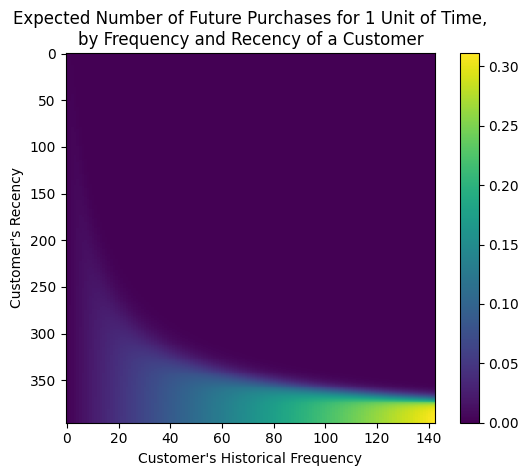

In [10]:
plot_frequency_recency_matrix(model)

Podemos ver que si un cliente ha interactuado más de 120 veces, y su última interacción la realizó luego de 350 días de estar activo, entonces podemos considerarlo como uno de los mejores clientes (abajo a la derecha). Los clientes más fríos son los que están en la esquina superior derecha: compraron mucho rápido y no los hemos visto en semanas.

También está la “cola” alrededor (20,150). Eso representa al cliente que compra con poca frecuencia, pero lo hemos visto recientemente, por lo que podría volver a comprar; no estamos seguros de si ha dejado de ser cliente o solo está en un periodo entre compras.

Otra matriz interesante para observar es la probabilidad de seguir "vivo" o de continuar siendo cliente:

<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

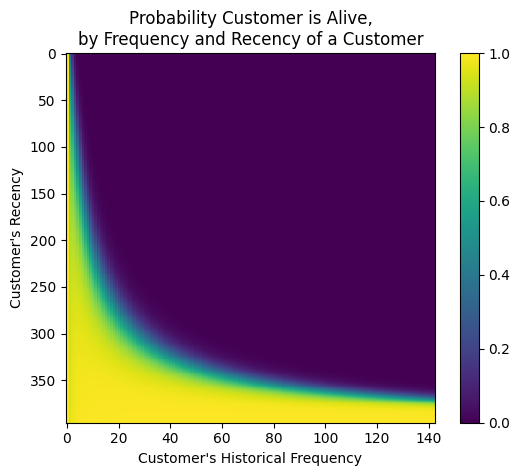

In [11]:
plot_probability_alive_matrix(model)


## Ordenando a los clientes de mejor a peor

Ahora vamos a clasificar a los clientes desde "las compras esperadas más altas en el próximo período" hasta las más bajas. El modelo permite predecir las compras esperadas de un cliente en el próximo período utilizando su historial.

In [12]:
t = 10
rfm_data['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(
    t, rfm_data['frequency'], rfm_data['recency'], rfm_data['T'])
rfm_data.sort_values(by='predicted_purchases').tail(5)


,frequency,recency,T,predicted_purchases
CustomerNo,,,,
14606.0,87.0,372.0,395.0,1.815463
15311.0,90.0,373.0,395.0,1.885566
14911.0,142.0,372.0,395.0,1.997234
17841.0,113.0,372.0,395.0,2.141693
12748.0,112.0,373.0,395.0,2.200841


Podemos ver que el cliente que ha realizado 129 compras, y nos compró muy recientemente, probablemente volverá a comprar en el próximo período.

## Evaluación del ajuste del modelo

Podemos predecir y podemos visualizar el comportamiento de nuestros clientes, pero ¿El modelo es correcto? En el siguiente gráfico se comparan sus datos con datos artificiales simulados con los parámetros del modelo ajustado.

<AxesSubplot: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

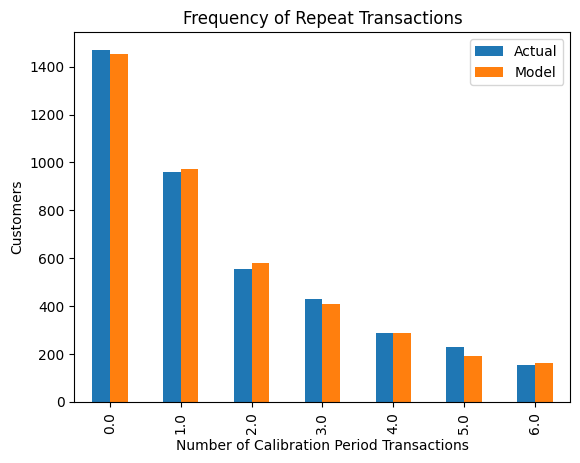

In [13]:
plot_period_transactions(model)



Podemos ver que nuestros datos reales y nuestros datos simulados se alinean bien. Esto prueba que nuestro modelo no es malo.

## Más ajuste del modelo

Con los datos transaccionales, podemos dividir el conjunto de datos en un grupo de datos de período de calibración y otro grupo de datos de reserva. Esto es importante ya que queremos probar cómo funciona nuestro modelo en datos que aún no se han visto (piense en la validación cruzada en la literatura estándar de aprendizaje automático). `btyd` tiene una función para particionar nuestro conjunto de datos de esta manera:

In [14]:
summary_cal_holdout = calibration_and_holdout_data(transactional_data, 'CustomerNo', 'Date',
                                                     calibration_period_end='2019-06-09',
                                                     observation_period_end='2019-12-09')
print(summary_cal_holdout.tail(5))

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerNo                                                         
18273.0               0.0          0.0   74.0                2.0   
18277.0               0.0          0.0  135.0                1.0   
18280.0               0.0          0.0   94.0                0.0   
18283.0               4.0        137.0  154.0                9.0   
18287.0               0.0          0.0   18.0                2.0   

            duration_holdout  
CustomerNo                    
18273.0                183.0  
18277.0                183.0  
18280.0                183.0  
18283.0                183.0  
18287.0                183.0  


Con este conjunto de datos, podemos realizar ajustes en las columnas `_cal` y probar en las columnas `_holdout`:

/home/dimitrio/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

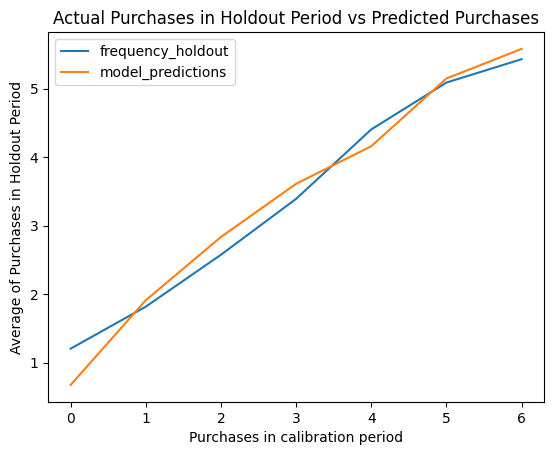

In [15]:
model.fit(summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(model, summary_cal_holdout)


## Predicciones de clientes
Con base en el historial del cliente, podemos predecir cómo serán las compras futuras de un individuo:

In [16]:
t = 10  # predecir compras en 10 periodos

individual = rfm_data.iloc[99] # Escoger el veinteavo individuo 

print(individual)
print(model.predict(t, individual['frequency'],
              individual['recency'], individual['T'])*100)


frequency                5.00000
recency                168.00000
T                      374.00000
predicted_purchases      0.09404
Name: 12383.0, dtype: float64
12.709584192467757


Aquí podemos observar que el individuo 12082 tiene una probabilidad aproximada del 2,03% de comprar en 10 periodos.

## Historiales de probabilidad de clientes
Dado el historial de transacciones de un cliente, podemos calcular su probabilidad histórica de seguir siendo cliente, de acuerdo con nuestro modelo entrenado. Por ejemplo:

       TransactionNo       Date  CustomerNo
4242          581381 2019-12-08     16933.0
6497         C581305 2019-12-08     16933.0
242414        562933 2019-08-10     16933.0
378579       C550484 2019-04-18     16933.0
381820        550132 2019-04-14     16933.0
382574       C550099 2019-04-14     16933.0


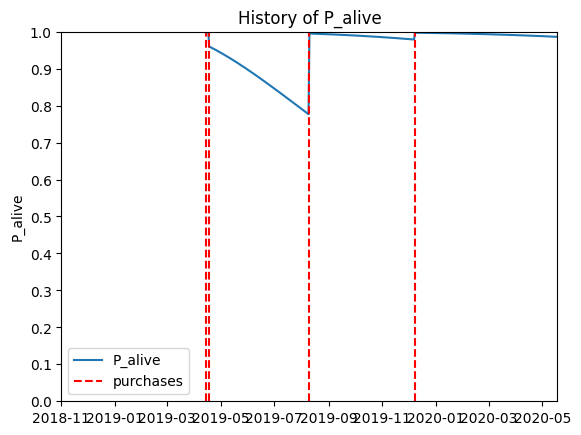

In [17]:
id = 16933
days_since_birth = 400
transactions = transactional_data.loc[transactional_data['CustomerNo'] == id]
plot_history_alive(model, days_since_birth, transactions,
                   'Date', start_date=datetime.datetime(2018, 11, 1))
print(transactions)


Podemos apreciar que este cliente compró con una frecuencia relativamente alta al inicio lo que ocasionó una caída en su probabilidad de ser cliente, luego realizó otra compra creando así un patrón con mayor espacio entre compras. Después de la tercera compra se puede ver como ahora el modelo penaliza menos los días sin compra.

       TransactionNo       Date  CustomerNo
318953        555928 2019-06-08     12383.0
380698        550284 2019-04-15     12383.0
418019        546434 2019-03-14     12383.0
473909       C541586 2019-01-19     12383.0
482471        540971 2019-01-12     12383.0
495385        539840 2018-12-22     12383.0


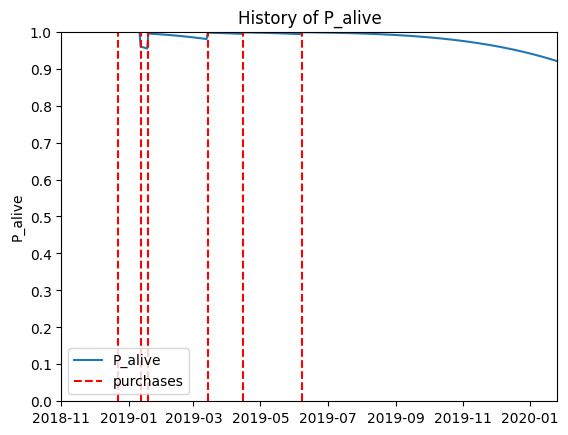

In [18]:
id = 12383
days_since_birth = 400
transactions = transactional_data.loc[transactional_data['CustomerNo'] == id]
plot_history_alive(model, days_since_birth, transactions,
                   'Date', start_date=datetime.datetime(2018, 11, 1))
print(transactions)


Aquí podemos apreciar el comportamiento de un cliente frecuente y como su probabilidad de ser cliente cae luego de seis meses sin comprar.

       TransactionNo       Date  CustomerNo
5303          581433 2019-12-08     14911.0
6595          581003 2019-12-07     14911.0
6670          581006 2019-12-07     14911.0
7266          581098 2019-12-07     14911.0
12554         580555 2019-12-05     14911.0
...              ...        ...         ...
524712        537386 2018-12-06     14911.0
530313        536975 2018-12-03     14911.0
532755        536803 2018-12-02     14911.0
534602        536540 2018-12-01     14911.0
534619        536541 2018-12-01     14911.0

[241 rows x 3 columns]


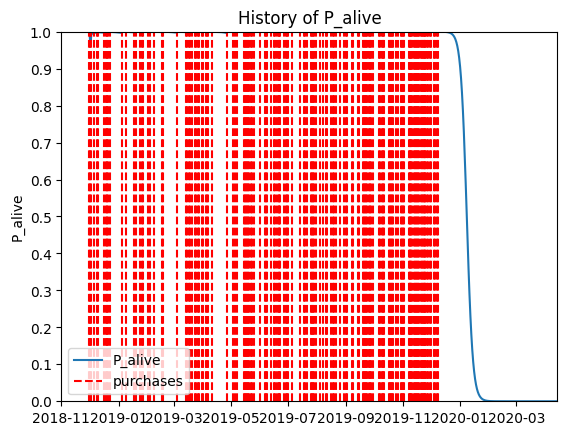

In [19]:
id = 14911
days_since_birth = 500
transactions = transactional_data.loc[transactional_data['CustomerNo'] == id]
plot_history_alive(model, days_since_birth, transactions,
                   'Date', start_date=datetime.datetime(2018, 11, 1))
print(transactions)


Este caso es interesante ya que vemos a un cliente que compra muy seguido durante todo el año, luego de pasar unos días sin comprar, el modelo penaliza fuertemente su probabilidad de seguir siendo cliente ya que no mantiene su comportamiento anterior.

       TransactionNo       Date  CustomerNo
20            581476 2019-12-09     12433.0
167           581491 2019-12-09     12433.0
26697         579692 2019-11-30     12433.0
118096        573035 2019-10-27     12433.0
206107        566195 2019-09-09     12433.0
519222        537868 2018-12-08     12433.0
534439        536532 2018-12-01     12433.0


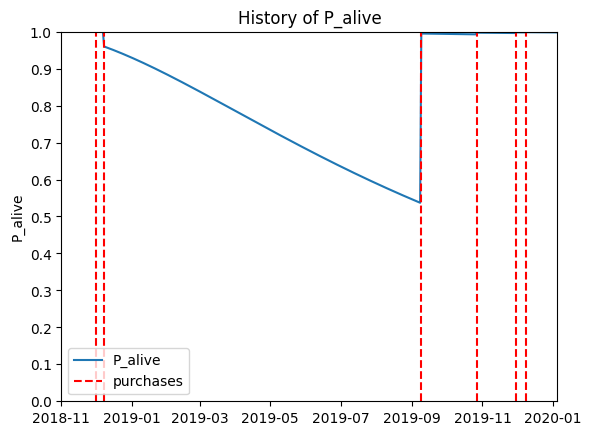

In [20]:
id = 12433
days_since_birth = 400
transactions = transactional_data.loc[transactional_data['CustomerNo'] == id]
plot_history_alive(model, days_since_birth, transactions,
                   'Date', start_date=datetime.datetime(2018, 11, 1))
print(transactions)


En este caso el cliente realizó dos compras y durante el año la probabilidad de vida del cliente fue disminuyendo pero no fue descartado, como vemos luego el cliente regresó y se completó su patrón de compra.

# Guardando el modelo

A continuación se guardará el modelo para su posterior uso en el sistema:

In [21]:
model.save_model('modelo.pkl')
model.save_model('../api/modelo.pkl')
